(cellular-structure:clustering)=
# Clustering
``````{dropdown} <i class="fa-solid fa-gear"></i>   Environment setup
`````{tab-set}

````{tab-item} Steps
```{include} ../_static/default_text_env_setup.md
```
````

````{tab-item} yml
```{literalinclude} clustering.yml
:language: yaml
```
````

`````
``````
<!-- END DROPDOWNS -->


```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: cellular-structure-clustering-key-takeaway-1
:link-type: ref
Use Leiden community detection on a single-cell KNN graph.
:::

:::{card}
:link: cellular-structure-clustering-key-takeaway-2
:link-type: ref
Sub-clustering with different resolution parameters allows the user to focus on more detailed substructures in the dataset to potentially identify finer cell states. 
:::

```

<!-- START ENV-SETUP -->
<!-- END ENV-SETUP -->

(cellular-structure-clustering-key-takeaway-1)=
(cellular-structure-clustering-key-takeaway-2)=
## Motivation

Preprocessing and visualization enabled us to describe our scRNA-seq dataset and reduce its dimensionality. Up to this point, we embedded and visualized cells to understand the underlying properties of our dataset. However, they are still rather abstractly defined. The next natural step in single-cell analysis is the identification of cellular structure in the dataset. 

In scRNA-seq data analysis, we describe cellular structure in our dataset with finding cell identities that relate to known cell states or cell cycle stages. This process is usually called cell identity annotation. For this purpose, we structure cells into clusters to infer the identity of similar cells. Clustering itself is a common unsupervised machine learning problem. 
We can derive clusters by minimizing the intra-cluster distance in the reduced expression space. In this case, the expression space determines the gene expression similarity of cells with respect to a dimensionality-reduced representation. This lower dimensional representation is, for example, determined with a principal-component analysis and the similarity scoring is then based on Euclidean distances. 

The KNN graph consists of nodes reflecting the cells in the dataset. We first calculate a Euclidean distance matrix on the PC-reduced expression space for all cells and then connect each cell to its K most similar cells. Usually, K is set to values between 5 and 100 depending on the size of the dataset. The KNN graph reflects the underlying topology of the expression data by representing dense regions with respect to expression space also as densely connected regions in the graph {cite}`wolf_paga_2019`. Dense regions in the KNN-graph are detected by community detection methods like Leiden and Louvain{cite}`blondel_fast_2008`. 

The Leiden algorithm is an improved version of the Louvain algorithm which outperformed other clustering methods for single-cell RNA-seq data analysis ({cite}`du_systematic_2018, freytag_comparison_2018, weber_comparison_2016`). Since the Louvain algorithm is no longer maintained, using Leiden instead is preferred. 

We, therefore, propose to use the Leiden algorithm{cite}`traag_louvain_2019` on single-cell k-nearest-neighbour (KNN) graphs to cluster single-cell datasets. 

Leiden creates clusters by taking into account the number of links between cells in a cluster versus the overall expected number of links in the dataset. 

:::{figure-md} clustering

<img src="../_static/images/clustering/clustering.jpeg" alt="Clustering Overview" class="bg-primary mb-1" width="800px">

The Leiden algorithm computes a clustering on a KNN graph obtained from the PC reduced expression space. It starts with an initial partition where each node forms its own community. Next, the algorithm moves single nodes from one community to another to find a partition, which is then refined. Based on a refined partition an aggregate network is generated, which is again refined until no further improvements can be obtained, and the final partition is reached. 

:::


The starting point is a singleton partition in which each node functions as its own community (a). As a next step, the algorithm creates partitions by moving individual nodes from one community to another (b), which is refined afterwards to enhance the partitioning (c). The refined partition is then aggregated to a network (d). Subsequently, the algorithm moves again individual nodes in the aggregate network (e), until refinement does no longer change the partition (f). All steps are repeated until the final clustering is created and partitions no longer change.

The Leiden module has a resolution parameter which allows to determine the scale of the partition cluster and therefore the coarseness of the clustering. A higher resolution parameter leads to more clusters. The algorithm additionally allows efficient sub-clustering of particular clusters in the dataset by sub-setting the KNN graph. Sub-clustering enables the user to identify cell-type specific states within clusters or a finer cell type labeling{cite}`wagner_revealing_2016`, but can also lead to patterns that are only due to noise present in the data.

As mentioned before, the Leiden algorithm is implemented in scanpy.

In [1]:
import scanpy as sc

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, facecolor="white", frameon=False)

## Clustering human bone marrow cells

Firstly, we load our dataset. We perform clustering on the preprocessed sample `site4-donor8` from the NeurIPS human bone marrow dataset which we already preprocessed. 

This dataset was normalized with log1pPF, scran and scTransform. We will focus on the scran normalized version of the dataset in this notebook as recommended in the preprocessing chapter to better identify substates of individual cells. 

In [2]:
adata = sc.read("s4d8_subset_gex.h5ad")

The Leiden algorithm leverages a KNN graph on the reduced expression space. We can calculate the KNN graph on a lower-dimensional gene expression representation with the scanpy function `sc.pp.neighbors`. We call this function on the top 30 principal-components as these capture most of the variance in the dataset. Visualizing the clustering can help us to understand the results, we therefore embed our cells into a UMAP embedding. More details can be found in the {ref}`pre-processing:dimensionality-reduction` chapter.

In [3]:
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)

/Users/anna.schaar/opt/miniconda3/envs/bp_pp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


We can now call the Leiden algorithm. 

In [4]:
sc.tl.leiden(adata)

The default resolution parameter in scanpy is 1.0. However, in many cases the analyst may want to try different resolution parameters to control the coarseness of the clustering. Hence, we recommend to save the clustering result under a specified key which indicates the selected resolution.

In [5]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

We now visualize the different clustering results obtained with the Leiden algorithm at different resolutions. As we can see, the resolution heavily influences how coarse our clustering is. Higher resolution parameters lead to more communities, i.e. more identified clusters, while lower resolution parameters lead to fewer communities. The resolution parameter therefore controls how densely clustered regions in the KNN-embedding are grouped together by the algorithm. This will become especially important for annotating the clusters. 

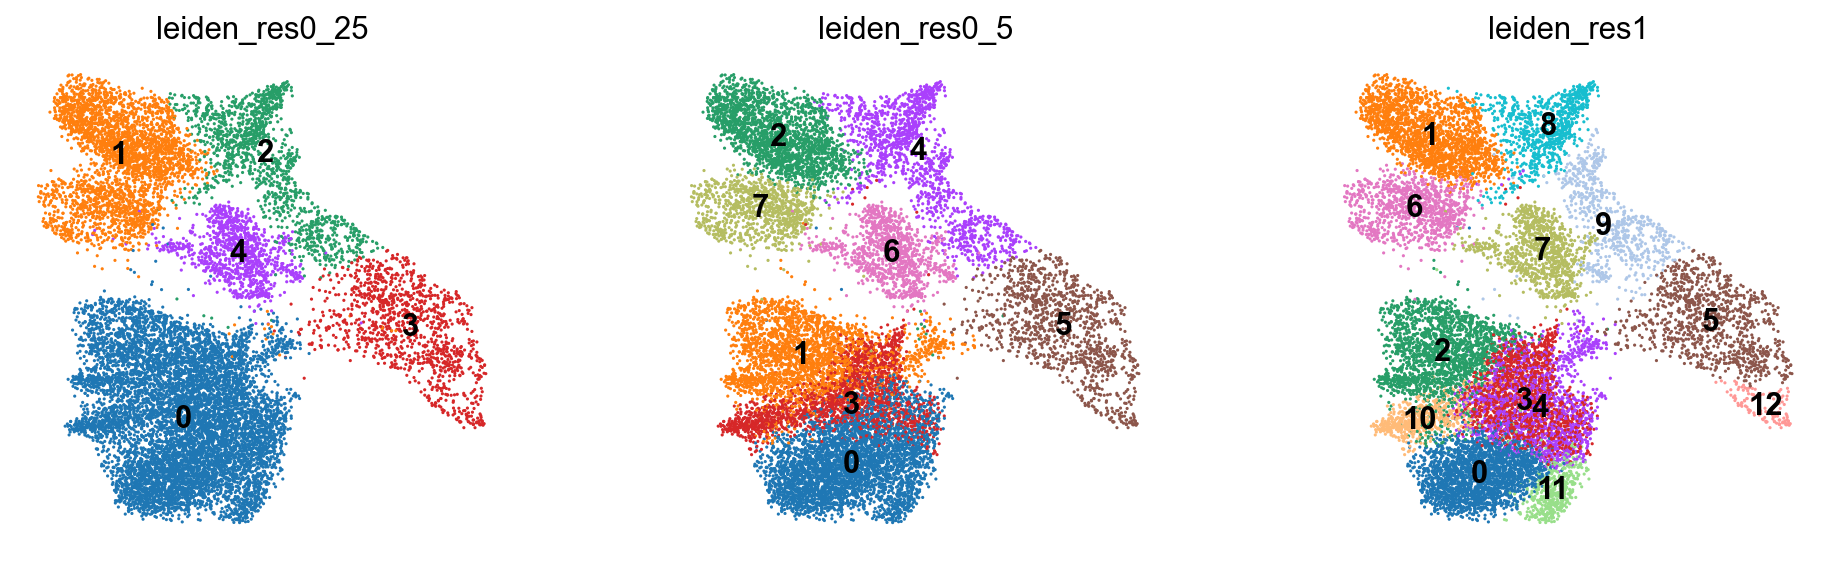

In [6]:
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

We now clearly inspect the impact of different resolutions on the clustering result. For a resolution of 0.25, the clustering is much coarser and the algorithm detected fewer communities. Additionally, clustered regions are less dense compared to the clustering obtained at a resolution of 1.0. 

We would like to highlight again that distances between the displayed clusters must be interpreted with caution. As the UMAP embedding is in 2D, distances are not necessarily captured well between all points. We recommend to not interpret distances between clusters visualized on UMAP embeddings.

## References

```{bibliography}
:filter: docname in docnames
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Anna Schaar

### Reviewers

* Lukas Heumos